Notebook on time series causality, part 3

TO DO:
 - Notebook still incomplete!

In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as sm_form
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.moment_helpers import corr2cov
np.random.seed(5000)

import rpy2
%load_ext rpy2.ipython

In [2]:
%%R 
library(dagitty)

In [3]:
%load_ext RWinOut

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## DGP

$
\begin{align*}
Y_{1,t} & = b_{1,1} Y_{1,t-1} + b_{1,3} Y_{3,t-1} + u_{1,t} \\
Y_{2,t} & = b_{2,1} Y_{1,t-1} + b_{2,2} Y_{2,t-1} + b_{2,3} Y_{3,t-1} + u_{2,t} + u_{1,t} \\
Y_{3,t} & = b_{3,3} Y_{3,t-1} + u_{3,t} + u_{1,t} \\
\end{align*}
$

where $t \geq 1$ and $
\begin{align*}
Y_0 = \begin{bmatrix} Y_{1,0} \\ Y_{2,0} \\ Y_{3,0} \end{bmatrix} = \begin{bmatrix} 0 \\ 0 \\ 0 \end{bmatrix}
\end{align*}
$

and with $b_{1,1} = 0.8$, $b_{1,3} = -0.55$, $b_{2,1} = -0.50$, $b_{2,2} = 0.7$, $b_{2,3} = -0.85$ and $b_{3,3} = -0.40$. 

Shocks correlation matrix:

$
\begin{align*}
\mathbf{\Sigma}_u = \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{bmatrix}
\end{align*}
$

In this DGP $Y_{1,t}$ and $Y_{2,t}$ are correlated through $Y_{1,t-1}$.

We are interested in effects $u_{1,t} \rightarrow y_{2,t+1}$ and $u_{1,t} \rightarrow y_{2,t+2}$. According to DGP the true affects are
 - $u_{1,t} \rightarrow y_{2,t+1}$: 1 (-0.5) + 1 (0.7) + 1 (-0.85) = -0.65
 - $u_{1,t} \rightarrow y_{2,t+2}$: -0.24
   - $u_{1,t} \rightarrow y_{1,t} \rightarrow y_{1,t+1} \rightarrow y_{2,t+2}$: 1 (0.8) (-0.50) = -0.40
   - $u_{1,t} \rightarrow y_{1,t} \rightarrow y_{2,t+1} \rightarrow y_{2,t+2}$: 1 (-0.50) (0.70) = -0.35
   - $u_{1,t} \rightarrow y_{1,t} \rightarrow y_{3,t+1} \rightarrow y_{2,t+2}$: 1 (0) (-0.85) = 0 
   - $u_{1,t} \rightarrow y_{2,t} \rightarrow y_{1,t+1} \rightarrow y_{2,t+2}$: 1 (0) (-0.50) = 0 
   - $u_{1,t} \rightarrow y_{2,t} \rightarrow y_{2,t+1} \rightarrow y_{2,t+2}$: 1 (0.70) (0.70) = 0.49
   - $u_{1,t} \rightarrow y_{2,t} \rightarrow y_{3,t+1} \rightarrow y_{2,t+2}$: 1 (0) (-0.85) = 0
   - $u_{1,t} \rightarrow y_{3,t} \rightarrow y_{1,t+1} \rightarrow y_{2,t+2}$: 1 (-0.55) (-0.50) = 0.275
   - $u_{1,t} \rightarrow y_{3,t} \rightarrow y_{2,t+1} \rightarrow y_{2,t+2}$: 1 (-0.85) (0.70) = -0.595
   - $u_{1,t} \rightarrow y_{3,t} \rightarrow y_{3,t+1} \rightarrow y_{2,t+2}$: 1 (-0.40) (-0.85) = 0.34

Directed acyclic graph of the DGP:

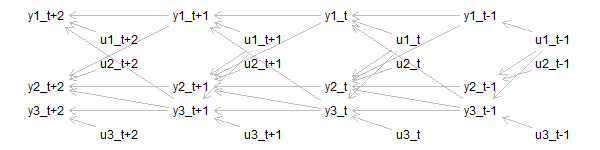

[1] "Adjustment set for u1_t direct effect on y2_t+1:"
{ y1_t, y2_t, y3_t }
[1] "--------------------"
[1] "Adjustment set for u1_t total effect on y2_t+1:"
 {}
[1] "---------------------------------------------------------------------"
[1] "Adjustment set for u1_t direct effect on y2_t+2:"
{ y1_t+1, y2_t+1, y3_t+1 }
{ u1_t+1, y1_t+1, y2_t+1, y3_t }
{ u1_t+1, y1_t, y2_t+1, y3_t }
{ y1_t, y2_t, y3_t }
[1] "--------------------"
[1] "Adjustment set for u1_t total effect on y2_t+2:"
 {}


In [4]:
%%R -h 150 -w 600
g = dagitty( 'dag {
    "y1_t+2" [pos="0,1"]
    "y2_t+2" [pos="0,4"]
    "u1_t+2" [pos="1,2"]
    "u2_t+2" [pos="1,3"]
    "y1_t+1" [pos="2,1"]
    "y2_t+1" [pos="2,4"]
    "u1_t+1" [pos="3,2"]
    "u2_t+1" [pos="3,3"]
    "y1_t"   [pos="4,1"]
    "y2_t"   [pos="4,4"]
    "u1_t"   [pos="5,2"]
    "u2_t"   [pos="5,3"]
    "y1_t-1" [pos="6,1"]
    "y2_t-1" [pos="6,4"]
    "u1_t-1" [pos="7,2"]
    "u2_t-1" [pos="7,3"]
    "y3_t+2" [pos="0,5"]
    "u3_t+2" [pos="1,6"]
    "y3_t+1" [pos="2,5"]
    "u3_t+1" [pos="3,6"]      
    "y3_t"   [pos="4,5"]
    "u3_t"   [pos="5,6"]      
    "y3_t-1" [pos="6,5"]
    "u3_t-1" [pos="7,6"]      
    "y1_t+2" <- "y1_t+1" <- "y1_t" <- "y1_t-1"
    "y2_t+2" <- "y2_t+1" <- "y2_t" <- "y2_t-1"
    "y1_t+2" <- "u1_t+2"
    "y1_t+1" <- "u1_t+1"
    "y1_t"   <- "u1_t"
    "y1_t-1" <- "u1_t-1"
    "y2_t+2" <- "u2_t+2"
    "y2_t+1" <- "u2_t+1"
    "y2_t"   <- "u2_t"
    "y2_t-1" <- "u2_t-1"
    "y2_t+2" <- "y1_t+1"
    "y2_t+1" <- "y1_t"
    "y2_t"   <- "y1_t-1"
    "y1_t+2" <- "y3_t+1" -> "y2_t+2"
    "y1_t+1" <- "y3_t" -> "y2_t+1"
    "y1_t"   <- "y3_t-1" -> "y2_t"
    "y3_t+2" <- "y3_t+1"
    "y3_t+1" <- "y3_t"
    "y3_t"   <- "y3_t-1"
    "y3_t+2" <- "u3_t+2"
    "y3_t+1" <- "u3_t+1"
    "y3_t"   <- "u3_t"
    "y3_t-1" <- "u3_t-1"
    "y2_t+1" <- "u1_t+1"
    "y2_t"   <- "u1_t"
    "y2_t-1" <- "u1_t-1"
    "y3_t+1" <- "u1_t+1"
    "y3_t"   <- "u1_t"
    "y3_t-1" <- "u1_t-1"
}')
plot(g)

print("Adjustment set for u1_t direct effect on y2_t+1:")
print(adjustmentSets(g, exposure="u1_t", outcome="y2_t+1", effect="direct"))
print("--------------------")
print("Adjustment set for u1_t total effect on y2_t+1:")
print(adjustmentSets(g, exposure="u1_t", outcome="y2_t+1", effect="total"))
print("---------------------------------------------------------------------")
print("Adjustment set for u1_t direct effect on y2_t+2:")
print(adjustmentSets(g, exposure="u1_t", outcome="y2_t+2", effect="direct"))
print("--------------------")
print("Adjustment set for u1_t total effect on y2_t+2:")
print(adjustmentSets(g, exposure="u1_t", outcome="y2_t+2", effect="total"))

### Simualate data according to DGP

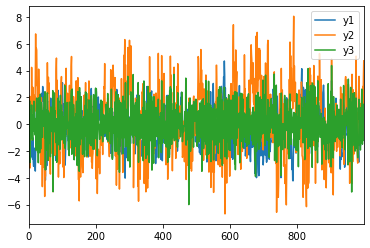

In [5]:
no_obs = 1000
initial_state = np.array([[0, 0, 0]]).T

# Coefficients
coefs = np.array([
       [0.80, 0, -0.55], 
       [-0.50, 0.70, -0.85],
       [0, 0, -0.40],       
])

# Generate array of u's
u_means = [0 ,0, 0]
u_stds = [1, 1, 1]
corrmat = [
    [1, 0, 0],
    [0, 1, 0],
    [0, 1, 1]
]
covmat = corr2cov(corrmat, u_stds)
u_array = np.random.multivariate_normal(
    mean=u_means,
    cov=covmat,
    size=no_obs
)

# Allocate aray for data
data_array = np.empty([no_obs, 3])
data_array[:] = np.nan
data_array[0, :] = initial_state.T

# Simulate data
for i in range(1, no_obs):
    # Error terms s in DGP
    shocks = u_array[i-1, :, np.newaxis]
    shocks[1, 0] = shocks[1, 0] + shocks[0, 0]
    shocks[2, 0] = shocks[2, 0] + shocks[0, 0]
    # Endognous variables 
    data_array[i, :] = (np.matmul(coefs, data_array[i-1, :, np.newaxis]) + shocks).T

df = pd.DataFrame(data_array, columns=["y1", "y2", "y3"])
_ = df.plot()

## Model 1: "Perfect model"

In first model we "guess" the structure correctly and fit a 3-variable reduced-form VAR(1) process to simualted data:

$
\begin{align*}
Y_{1,t} & = \beta_{1,1} Y_{1,t-1} + \beta_{1,2} Y_{1,t-1}+ \beta_{1,3} Y_{3,t-1} + \epsilon_{1,t} \\
Y_{2,t} & = \beta_{2,1} Y_{1,t-1} + \beta_{2,2} Y_{2,t-1}+ \beta_{2,3} Y_{3,t-1} + \epsilon_{2,t} \\
Y_{3,t} & = \beta_{3,1} Y_{1,t-1} + \beta_{3,2} Y_{2,t-1}+ \beta_{3,3} Y_{3,t-1} + \epsilon_{3,t} \\
\end{align*}
$

For structural identification/impulse responses we use Wold causal ordering (Cholesky decomposition) such that

$
\begin{align*}
\begin{bmatrix} \epsilon_{1,t}  \\ \epsilon_{2,t} \\ \epsilon_{3,t} \end{bmatrix} = \begin{bmatrix} ? & 0 & 0 \\ ? & ? & 0 \\ ? & ? & ? \end{bmatrix} \begin{bmatrix} \omega_{1,t} \\ \omega_{2,t} \\ \omega_{3,t} \end{bmatrix}
\end{align*}
$

Estimate VAR and similar SVAR:

In [6]:
model1_var = sm.tsa.VAR(df)
res1_var = model1_var.fit(maxlags=1)
irf1_var = res1_var.irf(5)

# SVAR
D = np.asarray([
    ["E", 0, 0],
    ["E", "E", 0],
    ["E", "E", "E"],    
])
model1_svar = sm.tsa.SVAR(df.copy(), svar_type='A', A=D)
res1_svar = model1_svar.fit(maxlags=1)
irf1_svar = res1_svar.irf(5)

### Estimation results - cofficients and residuals

Coefficients fairly well estimated.

In [7]:
res1_var.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 10, Sep, 2020
Time:                     13:24:51
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   0.148225
Nobs:                     999.000    HQIC:                  0.111687
Log likelihood:          -4285.16    FPE:                    1.09339
AIC:                    0.0892849    Det(Omega_mle):         1.08036
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        -0.023536         0.031191           -0.755           0.450
L1.y1         0.841204         0.026056           32.284           0.000
L1.y2         0.004126         0.014983            0.275           0.783
L1.y3        -0.565577

### Reduced-form residuals and structural shocks from SVAR

In [8]:
display(pd.DataFrame(np.corrcoef(res1_svar.resid, rowvar=False)))
# Put structural shocks into data frame; make sure time index matches as series is of length len(df)-1
resid1_structural = pd.DataFrame(np.matmul(res1_svar.A, res1_svar.resid.T).T, columns=df.columns, index=list(range(1, len(res1_svar.resid)+1)))
display(pd.DataFrame(np.corrcoef(resid1_structural, rowvar=False)))

,0,1,2
0,1.000000,0.625692,0.697584
1,0.625692,1.000000,0.664165
2,0.697584,0.664165,1.000000


,0,1,2
0,1.000000,-0.000002,0.000003
1,-0.000002,1.000000,-0.000002
2,0.000003,-0.000002,1.000000


### Structural impulse responses and structural impact multiplier matrix

We give two plots: strctural impulse responses from SVAR, and orthognalized impulse responeses from VAR. As our SVAR identifcation scheme is Wold causal ordering, results should coincide.

Our identification scheme allows for contemporaneous cross-effects $\omega_{2,t} \rightarrow y_{3,t}$ although in the DGP there is no such effect. We estimate a sizeable effect though, which is bad!

We get very accurate estimates for impacts $\omega_{1,t} \rightarrow y_{2,t+1}$ and $\omega_{1,t} \rightarrow y_{2,t+2}$.

In [9]:
display(pd.DataFrame(np.linalg.inv(res1_svar.A)))

,0,1,2
0,0.973786,0.000000,0.00000
1,0.967663,1.206410,0.00000
2,0.943219,0.394669,0.88477


Estimated effect of w1_t on y2_t+1 is about -0.55, while true value is -0.65
Estimated effect of w1_t on y2_t+2 is about -0.21, while true value is -0.24


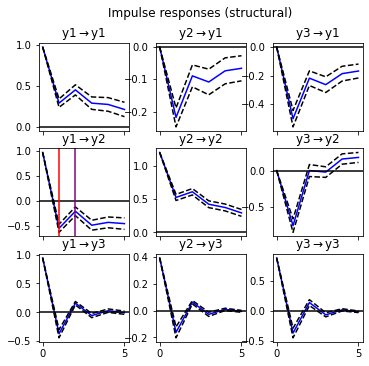

In [10]:
fig = irf1_svar.plot()
fig.suptitle(fig._suptitle.get_text(), fontsize=12)
fig.set_size_inches(5, 5)
plt.subplots_adjust(top=0.88, wspace=0.3)
ax = fig.get_axes()[3]
ax.axvline(x=1, c="r")
ax.axvline(x=2, c="purple")
print("Estimated effect of w1_t on y2_t+1 is about {:.2f}, while true value is {}".format(irf1_svar.svar_irfs[1, 1, 0], -0.65))
print("Estimated effect of w1_t on y2_t+2 is about {:.2f}, while true value is {}".format(irf1_svar.svar_irfs[2, 1, 0], -0.24))

For comparison, orthoganalized impulse responses from VAR

Estimated effect of w1_t on y2_t+1 is about -0.55, while true value is -0.65
Estimated effect of w1_t on y2_t+2 is about -0.21, while true value is -0.24


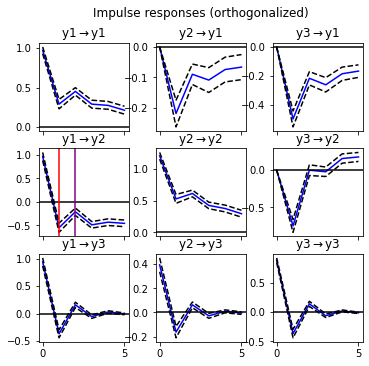

In [11]:
fig = irf1_var.plot(orth=True)
fig.suptitle(fig._suptitle.get_text(), fontsize=12)
fig.set_size_inches(5, 5)
plt.subplots_adjust(top=0.88, wspace=0.3)
ax = fig.get_axes()[3]
ax.axvline(x=1, c="r")
ax.axvline(x=2, c="purple")
print("Estimated effect of w1_t on y2_t+1 is about {:.2f}, while true value is {}".format(irf1_var.orth_irfs[1, 1, 0], -0.65))
print("Estimated effect of w1_t on y2_t+2 is about {:.2f}, while true value is {}".format(irf1_var.orth_irfs[2, 1, 0], -0.24))

### Replicate result of $\omega_{1,t}$ total effect on $y_{2, t+1}$ from impulse responses with a simple linear regression

In [12]:
# Prepare data for OLS
gg = pd.DataFrame()
gg["y2"] = df["y2"].copy()
gg["y1_l1"] = df["y1"].copy()
gg["y2_l1"] = df["y2"].copy()
gg["y3_l1"] = df["y3"].copy()
gg = gg.iloc[1:] # remove y_0 row
gg["y1_l1"] = gg["y1_l1"].shift(1)
gg["y2_l1"] = gg["y2_l1"].shift(1)
gg["y3_l1"] = gg["y3_l1"].shift(1)
gg["w1_l1"] = resid1_structural["y1"].copy().shift(1)
gg.dropna(inplace=True)

# Run OLS regression
ols_res = sm_form.ols(formula="y2 ~ w1_l1 -1", data=gg).fit()
print(ols_res.summary())

OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.053
Model:                            OLS   Adj. R-squared (uncentered):              0.052
Method:                 Least Squares   F-statistic:                              56.13
Date:                Thu, 10 Sep 2020   Prob (F-statistic):                    1.49e-13
Time:                        13:24:54   Log-Likelihood:                         -2308.6
No. Observations:                 998   AIC:                                      4619.
Df Residuals:                     997   BIC:                                      4624.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

What would happen if we controlled for $y_{1, t}$, $y_{2, t}$ and $y_{3, t}$? We would get *direct* effect of $\omega_{1, t}$, which is estimated around zero as expected. Estimates for lagged endogenous variables are fairly accurate.

In [13]:
ols_res = sm_form.ols(formula="y2 ~ y1_l1 + y2_l1 + y3_l1 + w1_l1 -1", data=gg).fit()
print(ols_res.summary())

OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.623
Model:                            OLS   Adj. R-squared (uncentered):              0.621
Method:                 Least Squares   F-statistic:                              410.6
Date:                Thu, 10 Sep 2020   Prob (F-statistic):                   9.17e-209
Time:                        13:24:54   Log-Likelihood:                         -1849.2
No. Observations:                 998   AIC:                                      3706.
Df Residuals:                     994   BIC:                                      3726.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

### Replicate result of $\omega_{1,t}$ total effect on $y_{2, t+2}$ from impulse responses with a simple linear regression

Checks out fairly well.

In [14]:
# Prepare data for OLS
gg = pd.DataFrame()
gg["y2"] = df["y2"].copy()
gg["y1_l1"] = df["y1"].copy()
gg["y2_l1"] = df["y2"].copy()
gg["y3_l1"] = df["y3"].copy()
gg = gg.iloc[1:] # remove y_0 row
gg["y1_l1"] = gg["y1_l1"].shift(2)
gg["y2_l1"] = gg["y2_l1"].shift(2)
gg["y3_l1"] = gg["y3_l1"].shift(2)
gg["w1_l2"] = resid1_structural["y1"].copy().shift(2)
gg.dropna(inplace=True)

# Run OLS regression
ols_res = sm_form.ols(formula="y2 ~ w1_l2 -1", data=gg).fit()
print(ols_res.summary())

OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.009
Model:                            OLS   Adj. R-squared (uncentered):              0.008
Method:                 Least Squares   F-statistic:                              9.438
Date:                Thu, 10 Sep 2020   Prob (F-statistic):                     0.00218
Time:                        13:24:54   Log-Likelihood:                         -2329.0
No. Observations:                 997   AIC:                                      4660.
Df Residuals:                     996   BIC:                                      4665.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

What would happen if we controlled for $y_{1, t}$, $y_{2, t}$ and $y_{3, t}$? We would get *direct* effect of $\omega_{1, t}$, which is estimated around zero as expected.

In [15]:
ols_res = sm_form.ols(formula="y2 ~ y1_l1 + y2_l1 + y3_l1 + w1_l2 -1", data=gg).fit()
print(ols_res.summary())

OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.426
Model:                            OLS   Adj. R-squared (uncentered):              0.424
Method:                 Least Squares   F-statistic:                              184.3
Date:                Thu, 10 Sep 2020   Prob (F-statistic):                   3.90e-118
Time:                        13:24:54   Log-Likelihood:                         -2056.9
No. Observations:                 997   AIC:                                      4122.
Df Residuals:                     993   BIC:                                      4141.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

## Model 2: Model with 2 variables

In second model we treat variable $Y_{3}$ as unobserved. We fit a 2-variable reduced-form VAR(1) process to simualted data:

$
\begin{align*}
Y_{1,t} & = \beta_{1,1} Y_{1,t-1} + \beta_{1,2} Y_{1,t-1}+ \beta_{1,3} Y_{3,t-1} + \epsilon_{1,t} \\
Y_{2,t} & = \beta_{2,1} Y_{1,t-1} + \beta_{2,2} Y_{2,t-1}+ \beta_{2,3} Y_{3,t-1} + \epsilon_{2,t} \\
\end{align*}
$

For structural identification/impulse responses we use Cholesky decomposition such that

$
\begin{align*}
\begin{bmatrix} \epsilon_{1,t}  \\ \epsilon_{2,t} \end{bmatrix} = \begin{bmatrix} ? & 0 \\ ? & ? \end{bmatrix} \begin{bmatrix} \omega_{1,t} \\ \omega_{2,t} \end{bmatrix}
\end{align*}
$

Estimate VAR and similar SVAR:

In [16]:
# VAR
model2_var = sm.tsa.VAR(df[["y1", "y2"]])
res2_var = model2_var.fit(maxlags=1)
irf2_var = res2_var.irf(5)

# SVAR
D = np.asarray([
    ["E", 0],
    ["E", "E"],
])
model2_svar = sm.tsa.SVAR(df[["y1", "y2"]].copy(), svar_type='A', A=D)
res2_svar = model2_svar.fit(maxlags=1)
irf2_svar = res2_svar.irf(5)

### Estimation results - cofficients and residuals

Coefficients not that well estimated.

In [17]:
res2_var.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 10, Sep, 2020
Time:                     13:24:54
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   0.718657
Nobs:                     999.000    HQIC:                  0.700388
Log likelihood:          -3173.29    FPE:                    1.99210
AIC:                     0.689187    Det(Omega_mle):         1.98018
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        -0.032974         0.036558           -0.902           0.367
L1.y1         0.550135         0.024926           22.070           0.000
L1.y2        -0.159685         0.014483          -11.025           0.000

Results for equation 

### Reduced-form residuals and structural shocks from SVAR

In [18]:
display(pd.DataFrame(np.corrcoef(res2_svar.resid, rowvar=False)))
# Put structural shocks into data frame; make sure time index matches as series is of length len(df)-1
resid2_structural = pd.DataFrame(np.matmul(res2_svar.A, res2_svar.resid.T).T, columns=df.columns[:2], index=list(range(1, len(res2_svar.resid)+1)))
display(pd.DataFrame(np.corrcoef(resid2_structural, rowvar=False)))

,0,1
0,1.000000,0.723347
1,0.723347,1.000000


,0,1
0,1.000000e+00,-5.478210e-08
1,-5.478210e-08,1.000000e+00


### Structural impulse responses and structural impact multiplier matrix

As with model 1, we give two plots: strctural impulse responses from SVAR, and orthognalized impulse responeses from VAR.

Instantaneous impacts not well estimated. Desired effects $\omega_{1,t} \rightarrow y_{2,t+1}$ and $\omega_{1,t} \rightarrow y_{2,t+2}$ not accurate.

In [19]:
display(pd.DataFrame(np.linalg.inv(res2_svar.A)))

,0,1
0,1.141486,-8.220700e-17
1,1.291442,1.232769e+00


Estimated effect of w1_t on y2_t+1 is about -0.41, while true value is -0.65
Estimated effect of w1_t on y2_t+2 is about -0.57, while true value is -0.24


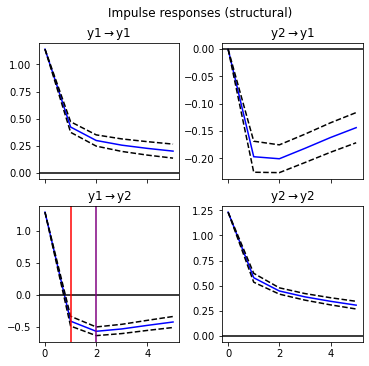

In [20]:
fig = irf2_svar.plot()
fig.suptitle(fig._suptitle.get_text(), fontsize=12)
fig.set_size_inches(5, 5)
plt.subplots_adjust(top=0.88, wspace=0.3)
_, _, ax, _ = fig.get_axes()
ax.axvline(x=1, c="r")
ax.axvline(x=2, c="purple")
print("Estimated effect of w1_t on y2_t+1 is about {:.2f}, while true value is {}".format(irf2_svar.svar_irfs[1, 1, 0], -0.65))
print("Estimated effect of w1_t on y2_t+2 is about {:.2f}, while true value is {}".format(irf2_svar.svar_irfs[2, 1, 0], -0.24))

Estimated effect of w1_t on y2_t+1 is about -0.41, while true value is -0.65
Estimated effect of w1_t on y2_t+2 is about -0.57, while true value is -0.24


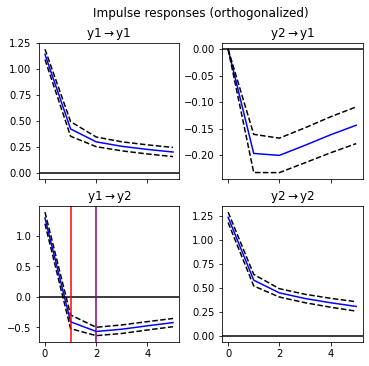

In [21]:
fig = irf2_var.plot(orth=True)
fig.suptitle(fig._suptitle.get_text(), fontsize=12)
fig.set_size_inches(5, 5)
plt.subplots_adjust(top=0.88, wspace=0.3)
_, _, ax, _ = fig.get_axes()
ax.axvline(x=1, c="r")
ax.axvline(x=2, c="purple")
print("Estimated effect of w1_t on y2_t+1 is about {:.2f}, while true value is {}".format(irf2_var.orth_irfs[1, 1, 0], -0.65))
print("Estimated effect of w1_t on y2_t+2 is about {:.2f}, while true value is {}".format(irf2_var.orth_irfs[2, 1, 0], -0.24))

### Replicate result of $\omega_{1,t}$ total effect on $y_{2, t+1}$ from impulse responses with a simple linear regression
Point-estimate not that accrate, but seems slightly more accurate than the impulse-response of mis-specified VAR. Not sure why this is.

In [22]:
# Prepare data for OLS
gg = pd.DataFrame()
gg["y2"] = df["y2"].copy()
gg["y1_l1"] = df["y1"].copy()
gg["y2_l1"] = df["y2"].copy()
gg = gg.iloc[1:] # remove y_0 row
gg["y1_l1"] = gg["y1_l1"].shift(1)
gg["y2_l1"] = gg["y2_l1"].shift(1)
gg["w1_l1"] = resid2_structural["y1"].copy().shift(1)
gg.dropna(inplace=True)

# Run OLS regression
ols_res = sm_form.ols(formula="y2 ~ w1_l1 -1", data=gg).fit()
print(ols_res.summary())

OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.035
Model:                            OLS   Adj. R-squared (uncentered):              0.034
Method:                 Least Squares   F-statistic:                              36.49
Date:                Thu, 10 Sep 2020   Prob (F-statistic):                    2.17e-09
Time:                        13:24:56   Log-Likelihood:                         -2318.0
No. Observations:                 998   AIC:                                      4638.
Df Residuals:                     997   BIC:                                      4643.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

What would happen if we controlled for $y_{1, t}$ and $y_{2, t}$? Effect for $\omega_{1,t}$ on $y_{2, t+1}$ now closer to it strue value! Why? Probably just biased and by luck more corect. Figure out how this bias comes about!

In [23]:
ols_res = sm_form.ols(formula="y2 ~ y1_l1 + y2_l1 + w1_l1 -1", data=gg).fit()
print(ols_res.summary())

OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.502
Model:                            OLS   Adj. R-squared (uncentered):              0.501
Method:                 Least Squares   F-statistic:                              334.4
Date:                Thu, 10 Sep 2020   Prob (F-statistic):                   3.85e-150
Time:                        13:24:56   Log-Likelihood:                         -1987.9
No. Observations:                 998   AIC:                                      3982.
Df Residuals:                     995   BIC:                                      3997.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

### Replicate result of $\omega_{1,t}$ total effect on $y_{2, t+2}$ from impulse responses with a simple linear regression

Quite god estimate, much better than what impulse response yields. However, if in the DGP we had $b_{2,3}=0.85$ instead of $b_{2,3}=-0.85$, this estimate would be quite bad. Why? Not totally sure yet. 

In [24]:
# Prepare data for OLS
gg = pd.DataFrame()
gg["y2"] = df["y2"].copy()
gg["y1_l1"] = df["y1"].copy()
gg["y2_l1"] = df["y2"].copy()
gg = gg.iloc[1:] # remove y_0 row
gg["y1_l1"] = gg["y1_l1"].shift(1)
gg["y2_l1"] = gg["y2_l1"].shift(1)
gg["w1_l2"] = resid2_structural["y1"].copy().shift(2)
gg.dropna(inplace=True)

# Run OLS regression
ols_res = sm_form.ols(formula="y2 ~ w1_l2 -1", data=gg).fit()
print(ols_res.summary())

OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.009
Model:                            OLS   Adj. R-squared (uncentered):              0.008
Method:                 Least Squares   F-statistic:                              9.365
Date:                Thu, 10 Sep 2020   Prob (F-statistic):                     0.00227
Time:                        13:24:56   Log-Likelihood:                         -2329.1
No. Observations:                 997   AIC:                                      4660.
Df Residuals:                     996   BIC:                                      4665.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

What would happen if we controlled for $y_{1, t}$ and $y_{2, t}$? Wildly biased estimate!

In [25]:
ols_res = sm_form.ols(formula="y2 ~ y1_l1 + y2_l1 + w1_l2 -1", data=gg).fit()
print(ols_res.summary())

OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.515
Model:                            OLS   Adj. R-squared (uncentered):              0.514
Method:                 Least Squares   F-statistic:                              352.0
Date:                Thu, 10 Sep 2020   Prob (F-statistic):                   1.02e-155
Time:                        13:24:56   Log-Likelihood:                         -1972.9
No. Observations:                 997   AIC:                                      3952.
Df Residuals:                     994   BIC:                                      3966.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

## Appendix

Can we say anythng aboout the estimated effect when $y_3$ is latent?

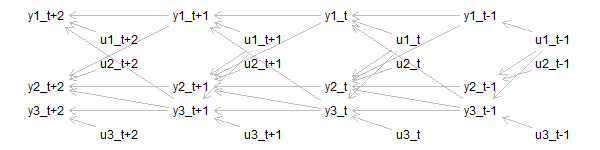

[1] "Adjustment set for u1_t direct effect on y2_t+1:"
[1] "--------------------"
[1] "Adjustment set for u1_t total effect on y2_t+1:"
 {}
[1] "---------------------------------------------------------------------"
[1] "Adjustment set for u1_t direct effect on y2_t+2:"
[1] "--------------------"
[1] "Adjustment set for u1_t total effect on y2_t+2:"
 {}


In [27]:
%%R -h 150 -w 600
g = dagitty( 'dag {
    "y1_t+2" [pos="0,1"]
    "y2_t+2" [pos="0,4"]
    "u1_t+2" [pos="1,2"]
    "u2_t+2" [pos="1,3"]
    "y1_t+1" [pos="2,1"]
    "y2_t+1" [pos="2,4"]
    "u1_t+1" [pos="3,2"]
    "u2_t+1" [pos="3,3"]
    "y1_t"   [pos="4,1"]
    "y2_t"   [pos="4,4"]
    "u1_t"   [pos="5,2"]
    "u2_t"   [pos="5,3"]
    "y1_t-1" [pos="6,1"]
    "y2_t-1" [pos="6,4"]
    "u1_t-1" [pos="7,2"]
    "u2_t-1" [pos="7,3"]
    "y3_t+2" [latent pos="0,5"]
    "u3_t+2" [latent pos="1,6"]
    "y3_t+1" [latent pos="2,5"]
    "u3_t+1" [latent pos="3,6"]      
    "y3_t"   [latent pos="4,5"]
    "u3_t"   [latent pos="5,6"]      
    "y3_t-1" [latent pos="6,5"]
    "u3_t-1" [latent pos="7,6"]      
    "y1_t+2" <- "y1_t+1" <- "y1_t" <- "y1_t-1"
    "y2_t+2" <- "y2_t+1" <- "y2_t" <- "y2_t-1"
    "y1_t+2" <- "u1_t+2"
    "y1_t+1" <- "u1_t+1"
    "y1_t"   <- "u1_t"
    "y1_t-1" <- "u1_t-1"
    "y2_t+2" <- "u2_t+2"
    "y2_t+1" <- "u2_t+1"
    "y2_t"   <- "u2_t"
    "y2_t-1" <- "u2_t-1"
    "y2_t+2" <- "y1_t+1"
    "y2_t+1" <- "y1_t"
    "y2_t"   <- "y1_t-1"
    "y1_t+2" <- "y3_t+1" -> "y2_t+2"
    "y1_t+1" <- "y3_t" -> "y2_t+1"
    "y1_t"   <- "y3_t-1" -> "y2_t"
    "y3_t+2" <- "y3_t+1"
    "y3_t+1" <- "y3_t"
    "y3_t"   <- "y3_t-1"
    "y3_t+2" <- "u3_t+2"
    "y3_t+1" <- "u3_t+1"
    "y3_t"   <- "u3_t"
    "y3_t-1" <- "u3_t-1"
    "y2_t+1" <- "u1_t+1"
    "y2_t"   <- "u1_t"
    "y2_t-1" <- "u1_t-1"
    "y3_t+1" <- "u1_t+1"
    "y3_t"   <- "u1_t"
    "y3_t-1" <- "u1_t-1"
}')
plot(g)

print("Adjustment set for u1_t direct effect on y2_t+1:")
print(adjustmentSets(g, exposure="u1_t", outcome="y2_t+1", effect="direct"))
print("--------------------")
print("Adjustment set for u1_t total effect on y2_t+1:")
print(adjustmentSets(g, exposure="u1_t", outcome="y2_t+1", effect="total"))
print("---------------------------------------------------------------------")
print("Adjustment set for u1_t direct effect on y2_t+2:")
print(adjustmentSets(g, exposure="u1_t", outcome="y2_t+2", effect="direct"))
print("--------------------")
print("Adjustment set for u1_t total effect on y2_t+2:")
print(adjustmentSets(g, exposure="u1_t", outcome="y2_t+2", effect="total"))